<a href="https://colab.research.google.com/github/erikstrand2/urban-data-informatics/blob/master/Stage_I_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stage I: Preprocessing taxi, demographic, and COVID-19 data

## Setup


In [ ]:
#@title Geopandas installation
%%time 

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express

# %load_ext google.colab.data_table

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources python3-rtree
0 upgraded, 5 newly installed, 0 to remove and 14 not upgraded.
Need to get 671 kB of archives.
After this operation, 3,948 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 

In [ ]:
!pip install mapclassify

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gp
import re
import matplotlib.pyplot as plt
import mapclassify

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Demographic data and NTA

This part extracts the census data and aggregates it into NTA

In [ ]:
# Get NTA geofile
NTA = gp.read_file('https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/ArcGIS/rest/services/NYC_Neighborhood_Tabulation_Areas/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson')

In [ ]:
# Get ACS data
ACS = pd.read_csv('/content/drive/MyDrive/IUDI Final Project/data/ACSST5Y2018.S0601_data_with_overlays_2020-11-24T234345.csv',skiprows=1)
ACS = ACS.set_index('id')
ACS = ACS.filter(regex=("Total!!"))
ACS = ACS.filter(regex=("!!Total population$|!!AGE!!|!!SEX!!|!!EDUCATIONAL ATTAINMENT!!|INCOME"))
ACS = ACS.replace('-',0)
ACS = ACS.apply(pd.to_numeric)
ACS = ACS.reset_index()
ACS['geoid'] = ACS['id'].apply(lambda x: str(int(x[-5:])))
ACS.head()

,id,Estimate!!Total!!Total population,Estimate!!Total!!Total population!!AGE!!Under 5 years,Estimate!!Total!!Total population!!AGE!!5 to 17 years,Estimate!!Total!!Total population!!AGE!!18 to 24 years,Estimate!!Total!!Total population!!AGE!!25 to 44 years,Estimate!!Total!!Total population!!AGE!!45 to 54 years,Estimate!!Total!!Total population!!AGE!!55 to 64 years,Estimate!!Total!!Total population!!AGE!!65 to 74 years,Estimate!!Total!!Total population!!AGE!!75 years and over,Estimate!!Total!!Total population!!AGE!!Median age (years),Estimate!!Total!!Total population!!SEX!!Male,Estimate!!Total!!Total population!!SEX!!Female,Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over,Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Less than high school graduate,Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!High school graduate (includes equivalency),Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Some college or associate's degree,Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree,Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Graduate or professional degree,Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over,"Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$1 to $9,999 or loss","Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$10,000 to $14,999","Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$15,000 to $24,999","Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$25,000 to $34,999","Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$35,000 to $49,999","Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$50,000 to $64,999","Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$65,000 to $74,999","Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$75,000 or more",Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!Median income (dollars),geoid
0,1400000US36061000100,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,100
1,1400000US36061000201,2835,5.3,17.1,7.9,31.1,8.5,11.6,8.0,10.4,40.5,43.0,57.0,1976,51.8,26.4,10.5,8.9,2.4,2313,28.2,13.5,12.9,14.1,5.8,3.8,0.1,3.5,14763,201
2,1400000US36061000202,7764,5.7,12.0,7.5,23.9,16.3,15.1,10.9,8.8,45.6,43.3,56.7,5814,28.9,21.5,17.2,20.0,12.5,6605,26.3,12.6,12.6,7.5,8.0,5.3,3.3,10.2,17159,202
3,1400000US36061000500,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,500
4,1400000US36061000600,9731,5.4,8.5,6.0,21.7,15.9,14.6,11.5,16.4,49.0,47.1,52.9,7794,55.4,18.0,11.5,9.0,6.1,8572,33.8,14.5,13.2,4.1,5.8,2.9,1.6,4.2,11969,600


In [ ]:
# Get translation census tract ACS and NTA
eq_TractNTA = pd.read_excel('/content/drive/MyDrive/IUDI Final Project/data/nyc2010census_tabulation_equiv.xlsx',skiprows=3)
eq_TractNTA = eq_TractNTA[eq_TractNTA['Borough'] == 'Manhattan']
eq_TractNTA['geoid'] = eq_TractNTA['2010 Census Tract'].apply(lambda x: str(round(x)))
TractNTA = pd.merge(ACS,eq_TractNTA,how='left',on='geoid')
TractNTA.head()

,id,Estimate!!Total!!Total population,Estimate!!Total!!Total population!!AGE!!Under 5 years,Estimate!!Total!!Total population!!AGE!!5 to 17 years,Estimate!!Total!!Total population!!AGE!!18 to 24 years,Estimate!!Total!!Total population!!AGE!!25 to 44 years,Estimate!!Total!!Total population!!AGE!!45 to 54 years,Estimate!!Total!!Total population!!AGE!!55 to 64 years,Estimate!!Total!!Total population!!AGE!!65 to 74 years,Estimate!!Total!!Total population!!AGE!!75 years and over,Estimate!!Total!!Total population!!AGE!!Median age (years),Estimate!!Total!!Total population!!SEX!!Male,Estimate!!Total!!Total population!!SEX!!Female,Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over,Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Less than high school graduate,Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!High school graduate (includes equivalency),Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Some college or associate's degree,Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree,Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Graduate or professional degree,Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over,"Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$1 to $9,999 or loss","Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$10,000 to $14,999","Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$15,000 to $24,999","Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$25,000 to $34,999","Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$35,000 to $49,999","Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$50,000 to $64,999","Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$65,000 to $74,999","Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$75,000 or more",Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!Median income (dollars),geoid,Borough,2010 Census Bureau FIPS County Code,2010 NYC Borough Code,2010 Census Tract,PUMA,Neighborhood Tabulation Area (NTA),Unnamed: 6
0,1400000US36061000100,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,100,Manhattan,61.0,1.0,100.0,3810.0,MN99,park-cemetery-etc-Manhattan
1,1400000US36061000201,2835,5.3,17.1,7.9,31.1,8.5,11.6,8.0,10.4,40.5,43.0,57.0,1976,51.8,26.4,10.5,8.9,2.4,2313,28.2,13.5,12.9,14.1,5.8,3.8,0.1,3.5,14763,201,Manhattan,61.0,1.0,201.0,3809.0,MN28,Lower East Side
2,1400000US36061000202,7764,5.7,12.0,7.5,23.9,16.3,15.1,10.9,8.8,45.6,43.3,56.7,5814,28.9,21.5,17.2,20.0,12.5,6605,26.3,12.6,12.6,7.5,8.0,5.3,3.3,10.2,17159,202,Manhattan,61.0,1.0,202.0,3809.0,MN28,Lower East Side
3,1400000US36061000500,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,500,Manhattan,61.0,1.0,500.0,3810.0,MN99,park-cemetery-etc-Manhattan
4,1400000US36061000600,9731,5.4,8.5,6.0,21.7,15.9,14.6,11.5,16.4,49.0,47.1,52.9,7794,55.4,18.0,11.5,9.0,6.1,8572,33.8,14.5,13.2,4.1,5.8,2.9,1.6,4.2,11969,600,Manhattan,61.0,1.0,600.0,3809.0,MN28,Lower East Side


In [ ]:
# Calculate ACS in absolute values
for column in ACS.columns[2:10]:
    TractNTA[column] = TractNTA[column]*TractNTA.iloc[:,1]/100
for column in ACS.columns[11:13]:
    TractNTA[column] = TractNTA[column]*TractNTA.iloc[:,1]/100
for column in ACS.columns[13:19]:
    TractNTA[column] = TractNTA[column]*TractNTA.iloc[:,12]/100
for column in ACS.columns[20:28]:
    TractNTA[column] = TractNTA[column]*TractNTA.iloc[:,19]/100

TractNTA.head()

,id,Estimate!!Total!!Total population,Estimate!!Total!!Total population!!AGE!!Under 5 years,Estimate!!Total!!Total population!!AGE!!5 to 17 years,Estimate!!Total!!Total population!!AGE!!18 to 24 years,Estimate!!Total!!Total population!!AGE!!25 to 44 years,Estimate!!Total!!Total population!!AGE!!45 to 54 years,Estimate!!Total!!Total population!!AGE!!55 to 64 years,Estimate!!Total!!Total population!!AGE!!65 to 74 years,Estimate!!Total!!Total population!!AGE!!75 years and over,Estimate!!Total!!Total population!!AGE!!Median age (years),Estimate!!Total!!Total population!!SEX!!Male,Estimate!!Total!!Total population!!SEX!!Female,Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over,Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Less than high school graduate,Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!High school graduate (includes equivalency),Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Some college or associate's degree,Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree,Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Graduate or professional degree,Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over,"Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$1 to $9,999 or loss","Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$10,000 to $14,999","Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$15,000 to $24,999","Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$25,000 to $34,999","Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$35,000 to $49,999","Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$50,000 to $64,999","Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$65,000 to $74,999","Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$75,000 or more",Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!Median income (dollars),geoid,Borough,2010 Census Bureau FIPS County Code,2010 NYC Borough Code,2010 Census Tract,PUMA,Neighborhood Tabulation Area (NTA),Unnamed: 6
0,1400000US36061000100,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,100,Manhattan,61.0,1.0,100.0,3810.0,MN99,park-cemetery-etc-Manhattan
1,1400000US36061000201,2835,150.255,484.785,223.965,881.685,240.975,328.860,226.800,294.840,40.5,1219.050,1615.950,31931.17200,837.062100,426.61080,169.674750,143.81955,38.782800,2313,652.266,312.255,298.377,326.133,134.154,87.894,2.313,80.955,14763,201,Manhattan,61.0,1.0,201.0,3809.0,MN28,Lower East Side
2,1400000US36061000202,7764,442.548,931.680,582.300,1855.596,1265.532,1172.364,846.276,683.232,45.6,3361.812,4402.188,255943.21032,1272.232332,946.47042,757.176336,880.43760,550.273500,6605,1737.115,832.230,832.230,495.375,528.400,350.065,217.965,673.710,17159,202,Manhattan,61.0,1.0,202.0,3809.0,MN28,Lower East Side
3,1400000US36061000500,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,500,Manhattan,61.0,1.0,500.0,3810.0,MN99,park-cemetery-etc-Manhattan
4,1400000US36061000600,9731,525.474,8

In [ ]:
# Generate ACS in geofile
NTAPopulation = TractNTA.groupby('Neighborhood Tabulation Area (NTA)').sum()
NTAPopulationGeo = pd.merge(NTAPopulation,NTA,how='left',left_on='Neighborhood Tabulation Area (NTA)',right_on='NTACode')
NTAPopulationGeo = gp.GeoDataFrame(NTAPopulationGeo,crs='EPSG:4326',geometry='geometry')
NTAPopulationGeo.head()
##NTAPopulationGeo.plot(column='Estimate!!Total!!Total population',legend=True)

#plt.axis('off')

,Estimate!!Total!!Total population,Estimate!!Total!!Total population!!AGE!!Under 5 years,Estimate!!Total!!Total population!!AGE!!5 to 17 years,Estimate!!Total!!Total population!!AGE!!18 to 24 years,Estimate!!Total!!Total population!!AGE!!25 to 44 years,Estimate!!Total!!Total population!!AGE!!45 to 54 years,Estimate!!Total!!Total population!!AGE!!55 to 64 years,Estimate!!Total!!Total population!!AGE!!65 to 74 years,Estimate!!Total!!Total population!!AGE!!75 years and over,Estimate!!Total!!Total population!!AGE!!Median age (years),Estimate!!Total!!Total population!!SEX!!Male,Estimate!!Total!!Total population!!SEX!!Female,Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over,Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Less than high school graduate,Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!High school graduate (includes equivalency),Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Some college or associate's degree,Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree,Estimate!!Total!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Graduate or professional degree,Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over,"Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$1 to $9,999 or loss","Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$10,000 to $14,999","Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$15,000 to $24,999","Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$25,000 to $34,999","Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$35,000 to $49,999","Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$50,000 to $64,999","Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$65,000 to $74,999","Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!$75,000 or more",Estimate!!Total!!INDIVIDUALS' INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 15 years and over!!Median income (dollars),2010 Census Bureau FIPS County Code,2010 NYC Borough Code,2010 Census Tract,PUMA,OBJECTID,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape__Area,Shape__Length,geometry
0,52922,3258.786,7657.150,4906.304,17037.718,7191.019,5805.146,4314.578,2735.144,262.6,24959.899,27962.101,1.731266e+06,7621.772947,5496.189399,6710.529916,5039.484239,3098.080014,43746,8224.408,4903.912,6289.176,4932.279,3979.110,2911.683,1626.413,4809.014,192567,427.0,7.0,209700.0,26607.0,79,1,Manhattan,061,MN01,Marble Hill-Inwood,1.773272e+07,31844.333429,"MULTIPOLYGON (((-73.92152 40.85661, -73.92159 ..."
1,86117,6413.088,11833.941,8279.028,29427.145,11696.000,9328.778,5057.468,4084.180,561.8,38453.680,47663.320,2.029293e+06,9327.091542,11394.954841,11474.914199,8764.749919,6697.850967,70401,12627.303,7567.958,8363.848,5915.838,7057.522,6402.155,2012.410,9448.639,490461,976.0,16.0,362306.0,60848.0,74,1,Manhattan,061,MN03,Central Harlem North-Polo Grounds,2.540349e+07,27983.841731,"POLYGON ((-73.93445 40.83599, -73.93456 40.835..."
2,52700,2692.562,6715.124,5117.492,19520.898,7696.995,5382.058,2697.475,2867.127,241.0,26863.089,25836.911,1.473620e+06,6451.328183,5316.606556,4577.948854,5516.373001,3991.146548,44895,7486.298,4275.088,7118.635,4927.450,5151.462,3656.003,1387.938,4994.420,187162,427.0,7.0,161701.0,26614.0,101,1,Manhattan,061

In [ ]:
# Save result
print(NTAPopulationGeo.crs)
NTAPopulationGeo = NTAPopulationGeo.to_crs(epsg=2263)

NTAPopulationGeo.to_file('/content/drive/MyDrive/IUDI Final Project/output/NTAPopulationGeo.shp')

epsg:2263


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """


## COVID-19 data and NTA

This part extracts the COVID-19 and aggregates it into NTA

In [ ]:
covid_data = pd.read_csv('/content/drive/MyDrive/IUDI Final Project/data/covid-data-by-modzcta.csv')
covid_data.head()

,MODIFIED_ZCTA,NEIGHBORHOOD_NAME,BOROUGH_GROUP,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,574,2078.72,27613.09,28,101.40,4.28,11901
1,10002,Chinatown/Lower East Side,Manhattan,1674,2222.44,75322.71,162,215.07,5.79,28709
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,888,1645.12,53977.81,35,64.84,2.96,29470
3,10004,Financial District,Manhattan,67,2254.29,2972.12,1,33.65,3.57,1875
4,10005,Financial District,Manhattan,138,1575.84,8757.23,2,22.84,3.42,3773


   BoroCode  ...                                           geometry
0         3  ...  POLYGON ((990897.900 169268.121, 990588.252 16...
1         4  ...  POLYGON ((1038593.459 221913.355, 1039369.281 ...
2         4  ...  POLYGON ((1022728.275 217530.808, 1023052.645 ...
3         4  ...  POLYGON ((1051539.660 201007.013, 1051920.726 ...
4         3  ...  POLYGON ((995746.857 161665.390, 995833.832 16...

[5 rows x 8 columns]


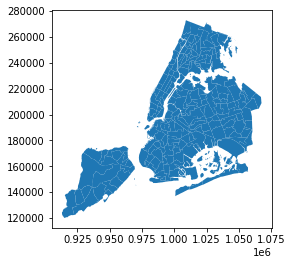

In [ ]:
nyc_nta = gp.read_file("/content/drive/MyDrive/IUDI Final Project/data/nynta_20d")

print(nyc_nta.head())
nyc_nta.plot()

  ZIPCODE BLDGZIP  ... SHAPE_LEN                                           geometry
0   11436       0  ...       0.0  POLYGON ((1038098.252 188138.380, 1038141.936 ...
1   11213       0  ...       0.0  POLYGON ((1001613.713 186926.440, 1002314.243 ...
2   11212       0  ...       0.0  POLYGON ((1011174.276 183696.338, 1011373.584 ...
3   11225       0  ...       0.0  POLYGON ((995908.365 183617.613, 996522.848 18...
4   11218       0  ...       0.0  POLYGON ((991997.113 176307.496, 992042.798 17...

[5 rows x 13 columns]


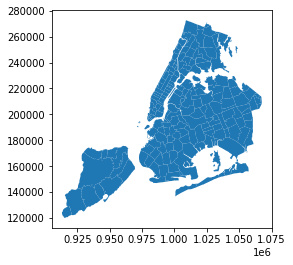

In [ ]:
nyc_zipcode = gp.read_file("/content/drive/MyDrive/IUDI Final Project/data/nyzip")

print(nyc_zipcode.head())
nyc_zipcode.plot()

(905416.3443840586, 1075095.183092714, 112379.68458807022, 280485.4658834085)

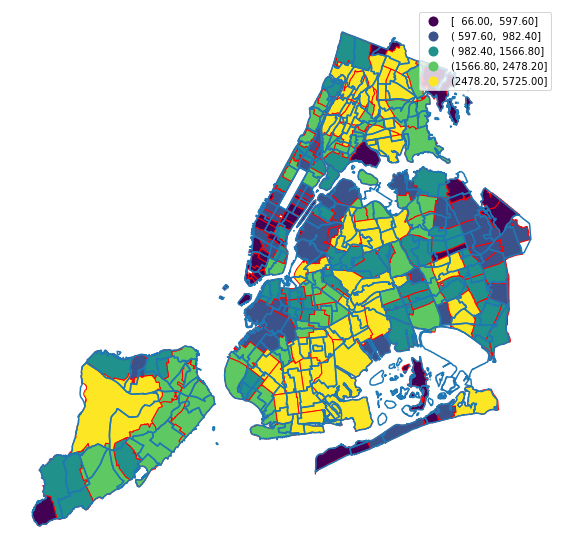

In [ ]:
nyc_zipcode["ZIPCODE"] = pd.to_numeric(nyc_zipcode["ZIPCODE"], downcast = "integer")
covid_byzip = nyc_zipcode.join(covid_data.set_index("MODIFIED_ZCTA"), on = "ZIPCODE")

plt = covid_byzip.plot(
    figsize = (10,10),
    column = 'COVID_CASE_COUNT', 
    scheme = 'quantiles', 
    legend = True, 
    edgecolor = "red"
  )
nyc_nta.boundary.plot(ax=plt)

plt.axis(False)

After this point, we realized that we had a spatial issue: COVID-19 data in NYC is only available at the zip code level, but we are doing our analysis at the NTA level. Rather than address this issue using the limited spatial tools in Python, I used ArcGIS to convert the COVID-19 data to NTA estimates. 

Broadly, my methodology for this was to import the COVID-19 data at the zip code level and use a weighted raster to split each zip code into proportions based on NTA boundaries. Using this method, I produced an output of COVID-19 data at the NTA level, which we use in the rest of our analysis. 

## Taxi data and NTA

This part extracts the yellow taxi data and aggregates it into NTA

In [ ]:
# Load taxi data
td20 = pd.read_csv('/content/drive/MyDrive/IUDI Final Project/data/yellow_tripdata_2020-01.csv',
                   usecols=['tpep_pickup_datetime','PULocationID'])
td19 = pd.read_csv('/content/drive/MyDrive/IUDI Final Project/data/yellow_tripdata_2019-01.csv',
                   usecols=['tpep_pickup_datetime','PULocationID'])
for month in range(2,7):
  print('Month:' + str(month), end = '\r')
  data20 = pd.read_csv('https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-0'+str(month)+'.csv',
                   usecols=['tpep_pickup_datetime','PULocationID'])
  td20 = pd.concat([td20,data20])
  data20 = 0
  data19 = pd.read_csv('https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-0'+str(month)+'.csv',
                   usecols=['tpep_pickup_datetime','PULocationID'])
  td19 = pd.concat([td19,data19])
  data19 = 0
print()

In [ ]:
# Load taxi zones
TaxiZones = gp.read_file('https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip')
TaxiZones = TaxiZones[TaxiZones['borough']=='Manhattan']
TaxiZones = TaxiZones.drop_duplicates(subset=['LocationID'])
TaxiZones = TaxiZones[['LocationID','geometry']]

In [ ]:
# Merge taxi data and zones
td19Geo = pd.merge(td19, TaxiZones, left_on='PULocationID',right_on='LocationID',how='left')
td20Geo = pd.merge(td20, TaxiZones, left_on='PULocationID',right_on='LocationID',how='left')
# Sanity check
print('Length match:')
len(td19Geo) + len(td20Geo) == len(td19) + len(td20)

Length match:


True

In [ ]:
td19Geo.to_csv('/content/drive/MyDrive/IUDI Final Project/output/tripdata_2019.csv',index=False)
td20Geo.to_csv('/content/drive/MyDrive/IUDI Final Project/output/tripdata_2020.csv',index=False)